# TBP SKIN CANCER DETECTION using DNNs / AdaBoost / CatBoost / XGBoost / Light GBR

## Importing Necessary Libraries

In [3]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE, SVMSMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import os
from PIL import Image
from tqdm import tqdm
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from torch.utils.data import DataLoader, Dataset
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, confusion_matrix
import xgboost as xgb
from catboost import CatBoostClassifier
import lightgbm as lgb
from torchvision import transforms
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.base import BaseEstimator, TransformerMixin
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import torch
from sklearn.svm import SVC

2024-08-01 22:04:44.892089: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-01 22:04:44.892209: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-01 22:04:44.999565: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import os
root_dir = '/kaggle/input'

for item in os.listdir(root_dir):
    item_path = os.path.join(root_dir, item)
    if os.path.isdir(item_path):
        print(f"Folder: {item}")
        for filename in os.listdir(item_path):
            file_path = os.path.join(item_path, filename)
            if os.path.isfile(file_path):
                print(file_path)
    elif os.path.isfile(item_path):
        print(item_path)
        
!ls /kaggle/input/isic-2024-challenge

Folder: isic-2024-challenge
/kaggle/input/isic-2024-challenge/sample_submission.csv
/kaggle/input/isic-2024-challenge/train-metadata.csv
/kaggle/input/isic-2024-challenge/test-metadata.csv
/kaggle/input/isic-2024-challenge/test-image.hdf5
/kaggle/input/isic-2024-challenge/train-image.hdf5


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


sample_submission.csv  test-metadata.csv  train-image.hdf5
test-image.hdf5        train-image	  train-metadata.csv


## Basic Data Exploration

In [5]:
df = pd.read_csv('/kaggle/input/isic-2024-challenge/train-metadata.csv', low_memory=False)
df.replace([float('inf'), float('-inf')], pd.NA, inplace=True)
df.drop_duplicates(inplace=True)
df.head()

positive_eg = df[df['target'] == 1]
negative_eg = df[df['target'] == 0]

final_test_df = pd.concat([positive_eg.copy()[:25], negative_eg.copy()[:25]]).reset_index().drop(columns = ['index'])


positive_eg = positive_eg.copy()[26:]
negative_eg = negative_eg.copy()[218:].sample(800)

#negative_eg = negative_eg.copy()[51:]

df = pd.concat([positive_eg, negative_eg]).reset_index().drop(columns = ['index'])

## Images/Tensor Data Model

In [6]:
test_images_id =  list(df['isic_id'])
test_images_target = list(df['target'])

In [7]:
image_folder = '/kaggle/input/isic-2024-challenge/train-image/image'

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

image_ids = []
tensors = []
targets = []

for image_id, target in tqdm(zip(test_images_id, test_images_target), total=len(test_images_id), desc="Processing Images"):
    image_path = os.path.join(image_folder, f"{image_id}.jpg")
    
    if os.path.exists(image_path):
        image = Image.open(image_path).convert('RGB')
        
        image_tensor = transform(image)
        
        image_ids.append(image_id)
        tensors.append(image_tensor)
        targets.append(target)
    else:
        print(f"Image {image_id} not found.")

image_df = pd.DataFrame({
    'tensor': tensors,
    'target': targets
})

Processing Images: 100%|██████████| 1167/1167 [00:08<00:00, 133.66it/s]


## Making a CNN Architecture

In [8]:
class ImageDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_tensor = self.df.iloc[idx]['tensor']
        target = self.df.iloc[idx]['target']
        return image_tensor, target

train_df, val_df = train_test_split(image_df, test_size=0.2, random_state=42)

train_dataset = ImageDataset(train_df)
val_dataset = ImageDataset(val_df)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.fc_input_size = 128 * (128 // 8) * (128 // 8)
        
        self.fc1 = nn.Linear(self.fc_input_size, 512)
        self.fc2 = nn.Linear(512, 1) 

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, self.fc_input_size)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

In [10]:
import torch.optim as optim

model = SimpleCNN()
criterion = nn.BCELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        optimizer.zero_grad()
        outputs = model(images).squeeze() 
        targets = targets.float().view(-1)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, targets in val_loader:
            outputs = model(images).squeeze()
            targets = targets.float().view(-1)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    print(f"Validation Loss: {val_loss/len(val_loader)}")

Epoch 1/10: 100%|██████████| 30/30 [00:19<00:00,  1.53it/s]


Epoch 1, Loss: 0.6427999436855316
Validation Loss: 0.6481789350509644


Epoch 2/10: 100%|██████████| 30/30 [00:18<00:00,  1.63it/s]


Epoch 2, Loss: 0.6135295808315278
Validation Loss: 0.6309515982866287


Epoch 3/10: 100%|██████████| 30/30 [00:18<00:00,  1.64it/s]


Epoch 3, Loss: 0.5683165341615677
Validation Loss: 0.4977377727627754


Epoch 4/10: 100%|██████████| 30/30 [00:17<00:00,  1.75it/s]


Epoch 4, Loss: 0.48700352509816486
Validation Loss: 0.499794602394104


Epoch 5/10: 100%|██████████| 30/30 [00:17<00:00,  1.67it/s]


Epoch 5, Loss: 0.4499438474575678
Validation Loss: 0.4473941996693611


Epoch 6/10: 100%|██████████| 30/30 [00:17<00:00,  1.71it/s]


Epoch 6, Loss: 0.4512908841172854
Validation Loss: 0.46112245693802834


Epoch 7/10: 100%|██████████| 30/30 [00:17<00:00,  1.74it/s]


Epoch 7, Loss: 0.4550415642559528
Validation Loss: 0.4372050128877163


Epoch 8/10: 100%|██████████| 30/30 [00:17<00:00,  1.68it/s]


Epoch 8, Loss: 0.4461034198602041
Validation Loss: 0.48085012286901474


Epoch 9/10: 100%|██████████| 30/30 [00:17<00:00,  1.73it/s]


Epoch 9, Loss: 0.4517517199118932
Validation Loss: 0.42714604921638966


Epoch 10/10: 100%|██████████| 30/30 [00:17<00:00,  1.68it/s]


Epoch 10, Loss: 0.4284345984458923
Validation Loss: 0.41026713140308857


In [11]:
torch.save(model.state_dict(), 'cnn_model.pth')

In [ ]:
def load_model_and_predict(image_tensor):
    model = SimpleCNN()
    model.load_state_dict(torch.load('cnn_model.pth'))
    model.eval()
    with torch.no_grad():
        output = model(image_tensor.unsqueeze(0))
        prediction = (output > 0.5).float()
    return prediction.item()

# Example usage
# Assume you have an image tensor ready for prediction
# image_tensor = some_image_tensor
# prediction = load_model_and_predict(image_tensor)
# print(f"Prediction: {prediction}")

## Textual Data Processing

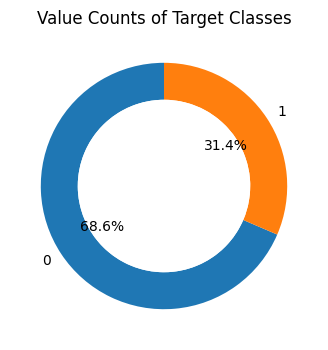

In [229]:
dist = df.target.value_counts()

plt.figure(figsize=(4, 4))
plt.pie(dist.values, labels=dist.index.astype(str), autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.3))

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Value Counts of Target Classes')
plt.show()

In [230]:
df_test = pd.read_csv('/kaggle/input/isic-2024-challenge/test-metadata.csv', low_memory=False)
df_test

,isic_id,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license
0,ISIC_0015657,IP_6074337,45.0,male,posterior torso,2.70,TBP tile: close-up,3D: XP,22.80433,20.007270,...,0.304827,1.281532,2.299935,0.479339,20,-155.06510,1511.222000,113.980100,Memorial Sloan Kettering Cancer Center,CC-BY
1,ISIC_0015729,IP_1664139,35.0,female,lower extremity,2.52,TBP tile: close-up,3D: XP,16.64867,9.657964,...,0.000000,1.271940,2.011223,0.426230,25,-112.36924,629.535889,-15.019287,"Frazer Institute, The University of Queensland...",CC-BY
2,ISIC_0015740,IP_7142616,65.0,male,posterior torso,3.16,TBP tile: close-up,3D: XP,24.25384,19.937380,...,0.230742,1.080308,2.705857,0.366071,110,-84.29282,1303.978000,-28.576050,FNQH Cairns,CC-BY


## Preprocessing Pipeline

In [231]:
df['tbp_lv_location_simple'] = df['tbp_lv_location_simple'].replace('Unknown', np.nan)

In [232]:
columns_to_drop = [
    'patient_id', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5', 'iddx_full', 'iddx_1',
    'mel_mitotic_index', 'mel_thick_mm', 'tbp_tile_type','lesion_id', 
    'attribution', 'copyright_license', 'image_type', 'isic_id','tbp_lv_dnn_lesion_confidence'
]

num_cols = [
    'age_approx', 'clin_size_long_diam_mm', 'tbp_lv_A', 'tbp_lv_Aext', 
    'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 
    'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2', 
    'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 
    'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm', 
    'tbp_lv_eccentricity', 'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 
    'tbp_lv_norm_border', 'tbp_lv_norm_color', 'tbp_lv_perimeterMM', 
    'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt', 
    'tbp_lv_symm_2axis', 'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z'
]

cat_cols = [
    'sex', 'anatom_site_general', 
    'tbp_lv_location', 'tbp_lv_location_simple', 
    'tbp_lv_symm_2axis_angle'
]

df.drop(columns=columns_to_drop, inplace=True)

In [233]:
target = list(df.target)

In [236]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, k=20):
        self.k = k
        self.selector = None

    def fit(self, X, y):
        self.selector = SelectKBest(score_func=f_classif, k=self.k)
        self.selector.fit(X, y)
        return self

    def transform(self, X):
        return X[:, self.selector.get_support(indices=True)]

    def get_feature_names_out(self, feature_names):
        return [feature_names[i] for i in self.selector.get_support(indices=True)]

class ColumnRenamer(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(X, columns=self.feature_names)

# Assuming num_cols and cat_cols are defined
pipeline = Pipeline(steps=[
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler())
            ]), num_cols),
            ('cat', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))
            ]), cat_cols)
        ]
    )),
    ('feature_selector', FeatureSelector(k=50)),
    ('column_renamer', ColumnRenamer([]))
])

X = df[num_cols + cat_cols]
y = df['target']

pipeline.fit(X, y)
preprocessor = pipeline.named_steps['preprocessor']
feature_selector = pipeline.named_steps['feature_selector']

feature_names = preprocessor.get_feature_names_out()

selected_feature_names = feature_selector.get_feature_names_out(feature_names)

pipeline.named_steps['column_renamer'].feature_names = selected_feature_names

X_reduced = pipeline.transform(X)

X_reduced_df = pd.DataFrame(X_reduced, columns=selected_feature_names)
X_reduced_df['target'] = y.values

X_reduced_df.head()

/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


,num__age_approx,num__clin_size_long_diam_mm,num__tbp_lv_A,num__tbp_lv_Aext,num__tbp_lv_B,num__tbp_lv_Bext,num__tbp_lv_C,num__tbp_lv_H,num__tbp_lv_Hext,num__tbp_lv_areaMM2,...,cat__tbp_lv_location_Unknown,cat__tbp_lv_location_simple_Head & Neck,cat__tbp_lv_location_simple_Right Arm,cat__tbp_lv_location_simple_Right Leg,cat__tbp_lv_location_simple_Torso Back,cat__tbp_lv_symm_2axis_angle_30,cat__tbp_lv_symm_2axis_angle_35,cat__tbp_lv_symm_2axis_angle_85,cat__tbp_lv_symm_2axis_angle_125,target
0,-1.047279,1.050635,-0.770941,-1.036116,0.185773,-0.198258,-0.243649,0.891155,0.958326,0.988109,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.446624,0.729350,2.388446,0.561751,-0.607171,-0.244769,0.913742,-2.241664,-0.692607,0.433400,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
2,0.820100,1.469388,2.411488,2.237058,-0.703556,0.234617,0.875963,-2.344273,-1.672057,0.767182,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
3,0.073148,-1.017861,3.626162,4.081093,0.166236,0.180651,2.124882,-2.224480,-2.792483,-0.596635,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.820100,4.368170,-1.288481,1.638982,-2.235422,-0.559205,-2.284231,-1.134743,-1.814781,5.203891,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1


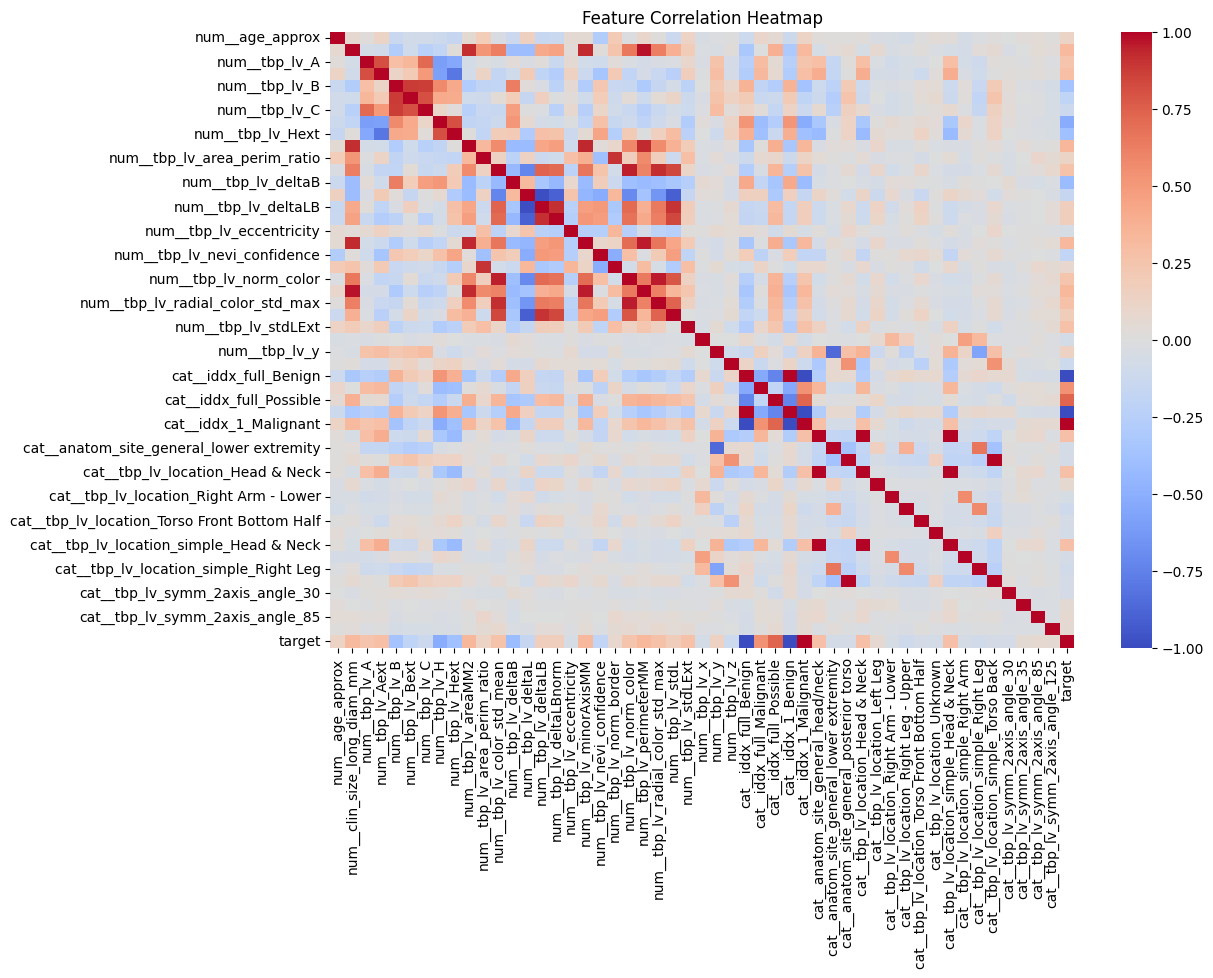

In [237]:
plt.figure(figsize=(12, 8))
correlation_matrix = X_reduced_df.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()


## Augementing Data using SMOTE


In [238]:
df = X_reduced_df

In [239]:
X = df.drop(columns=['target'])
y = df['target']

rus = SVMSMOTE(sampling_strategy='auto', random_state=42, k_neighbors=10)

X_resampled, y_resampled = rus.fit_resample(X, y)

df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled['target'] = y_resampled
df_resampled.drop_duplicates(inplace = True)

df = X_reduced_df

## Creating Modeling Structure

In [240]:
X_reduced_df.columns

Index(['num__age_approx', 'num__clin_size_long_diam_mm', 'num__tbp_lv_A',
       'num__tbp_lv_Aext', 'num__tbp_lv_B', 'num__tbp_lv_Bext',
       'num__tbp_lv_C', 'num__tbp_lv_H', 'num__tbp_lv_Hext',
       'num__tbp_lv_areaMM2', 'num__tbp_lv_area_perim_ratio',
       'num__tbp_lv_color_std_mean', 'num__tbp_lv_deltaB',
       'num__tbp_lv_deltaL', 'num__tbp_lv_deltaLB', 'num__tbp_lv_deltaLBnorm',
       'num__tbp_lv_eccentricity', 'num__tbp_lv_minorAxisMM',
       'num__tbp_lv_nevi_confidence', 'num__tbp_lv_norm_border',
       'num__tbp_lv_norm_color', 'num__tbp_lv_perimeterMM',
       'num__tbp_lv_radial_color_std_max', 'num__tbp_lv_stdL',
       'num__tbp_lv_stdLExt', 'num__tbp_lv_x', 'num__tbp_lv_y',
       'num__tbp_lv_z', 'cat__iddx_full_Benign', 'cat__iddx_full_Malignant',
       'cat__iddx_full_Possible', 'cat__iddx_1_Benign',
       'cat__iddx_1_Malignant', 'cat__anatom_site_general_head/neck',
       'cat__anatom_site_general_lower extremity',
       'cat__anatom_site_general_

In [241]:
base_features = ['num__clin_size_long_diam_mm', 'num__tbp_lv_A', 'num__tbp_lv_Aext',
       'num__tbp_lv_B', 'num__tbp_lv_Bext', 'num__tbp_lv_H',
       'num__tbp_lv_Hext', 'num__tbp_lv_areaMM2',
       'num__tbp_lv_area_perim_ratio', 'num__tbp_lv_color_std_mean',
       'num__tbp_lv_deltaB', 'num__tbp_lv_minorAxisMM',
       'num__tbp_lv_nevi_confidence', 'num__tbp_lv_norm_color',
       'num__tbp_lv_perimeterMM', 'num__tbp_lv_radial_color_std_max',
       'num__tbp_lv_stdL', 'num__tbp_lv_stdLExt', 'num__tbp_lv_z',
       'cat__anatom_site_general_head/neck',
       'cat__tbp_lv_location_Head & Neck',
       'cat__tbp_lv_location_simple_Head & Neck']

immediate_features = ['cat__iddx_full_Benign', 
                      'cat__iddx_full_Malignant',
                      'cat__iddx_full_Possible', 
                      'cat__iddx_1_Benign',
                      'cat__iddx_1_Malignant']

target_features = ['target']

In [242]:
df_1 = X_reduced_df[base_features + [immediate_features[0]]]
df_2 = X_reduced_df[base_features + [immediate_features[1]]]
df_3 = X_reduced_df[base_features + [immediate_features[2]]]
df_4 = X_reduced_df[base_features + [immediate_features[3]]]
df_5 = X_reduced_df[base_features + [immediate_features[4]]]

col = list(range(df_1.shape[1] - 1)) + ['target']
df_1.columns = col
df_2.columns = col
df_3.columns = col
df_4.columns = col
df_5.columns = col

df_f = X_reduced_df[immediate_features + target_features]
col = list(range(df_f.shape[1] - 1)) + ['target']
df_f.columns = col

base_dfs = [df_1, df_2, df_3, df_4, df_5]

## Applying Models

In [243]:
pAUCscores = []
confMatrix = []
cfReport = []

In [244]:
class ParticipantVisibleError(Exception):
    pass

def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, min_tpr: float=0.80) -> float:
    del solution[row_id_column_name]
    del submission[row_id_column_name]

    if not pd.api.types.is_numeric_dtype(submission.values):
        raise ParticipantVisibleError('Submission target column must be numeric')

    v_gt = abs(np.asarray(solution.values) - 1)
    v_pred = -1.0 * np.asarray(submission.values)

    max_fpr = abs(1 - min_tpr)

    fpr, tpr, _ = roc_curve(v_gt, v_pred, sample_weight=None)
    if max_fpr is None or max_fpr == 1:
        return auc(fpr, tpr)
    if max_fpr <= 0 or max_fpr > 1:
        raise ValueError("Expected min_tpr in range [0, 1), got: %r" % min_tpr)

    stop = np.searchsorted(fpr, max_fpr, "right")
    x_interp = [fpr[stop - 1], fpr[stop]]
    y_interp = [tpr[stop - 1], tpr[stop]]
    tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
    fpr = np.append(fpr[:stop], max_fpr)
    partial_auc = auc(fpr, tpr)

    return partial_auc


### Applying LightGBM

In [245]:
%%capture
def LightGBM(df: pd.DataFrame, save=False):
    X = df.drop(columns=['target'])
    y = df['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)

    lgb_model = lgb.LGBMClassifier()
    lgb_model.fit(X_train, y_train)
    y_scores = lgb_model.predict_proba(X_test)[:, 1]
    y_pred = (y_scores > 0.5).astype(int)
    solution = pd.DataFrame({'row_id': range(len(y_test)), 'target': y_test})
    submission = pd.DataFrame({'row_id': range(len(y_scores)), 'prediction': y_scores})
    pAUC = score(solution, submission, 'row_id', min_tpr=0.80)
    if save:
        pAUCscores.append(pAUC)
        confMatrix.append(confusion_matrix(y_test, y_pred))
        cfReport.append(classification_report(y_test, y_pred))
    
    return lgb_model, pAUC

### Applying XGBoost

In [246]:
def XGBoost(df: pd.DataFrame, save=False):
    X = df.drop(columns=['target'])
    y = df['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbose=3)
    xgb_model.fit(X_train, y_train)

    y_scores = xgb_model.predict_proba(X_test)[:, 1]
    y_pred = (y_scores > 0.5).astype(int)
    solution = pd.DataFrame({'row_id': range(len(y_test)), 'target': y_test})
    submission = pd.DataFrame({'row_id': range(len(y_scores)), 'prediction': y_scores})
    pAUC = score(solution, submission, 'row_id', min_tpr=0.80)
    if save:
        pAUCscores.append(pAUC)
        confMatrix.append(confusion_matrix(y_test, y_pred))
        cfReport.append(classification_report(y_test, y_pred))

    return [xgb_model, pAUC]

### Apply CATBoost

In [247]:
 def CATBoost(df:pd.DataFrame, save=False):
    X = df.drop(columns=['target'])
    y = df['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    catboost_model = CatBoostClassifier(verbose=0)
    catboost_model.fit(X_train, y_train)

    y_scores = catboost_model.predict_proba(X_test)[:, 1]
    y_pred = (y_scores > 0.5).astype(int)
    solution = pd.DataFrame({'row_id': range(len(y_test)), 'target': y_test})
    submission = pd.DataFrame({'row_id': range(len(y_scores)), 'prediction': y_scores})
    pAUC = score(solution, submission, 'row_id', min_tpr=0.80)
    if save:
        pAUCscores.append(pAUC)
        confMatrix.append(confusion_matrix(y_test, y_pred))
        cfReport.append(classification_report(y_test, y_pred))

    return [catboost_model, pAUC]

### Applying RF

In [248]:
def RandomForest(df:pd.DataFrame, save=False):
    X = df.drop(columns=['target'])
    y = df['target']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    random_forest_model = RandomForestClassifier(random_state=42, verbose=3)
    random_forest_model.fit(X_train, y_train)

    y_scores = random_forest_model.predict_proba(X_test)[:, 1]
    y_pred = (y_scores > 0.5).astype(int)
    solution = pd.DataFrame({'row_id': range(len(y_test)), 'target': y_test})
    submission = pd.DataFrame({'row_id': range(len(y_scores)), 'prediction': y_scores})
    pAUC = score(solution, submission, 'row_id', min_tpr=0.80)
    if save:
        pAUCscores.append(pAUC)
        confMatrix.append(confusion_matrix(y_test, y_pred))
        cfReport.append(classification_report(y_test, y_pred))

    
    return [random_forest_model,pAUC]

### Using Deep Neural Networks

In [249]:
def DNNetworks(df:pd.DataFrame, save=False):
    X = df.drop(columns=['target'])
    y = df['target']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],), ),
        Dense(128, activation='relu', ),
        Dense(32, activation='relu', ),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=15, validation_split=0.2, batch_size=32, verbose=4)
    loss, accuracy = model.evaluate(X_test, y_test)

    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    y_true = y_test

    y_scores = model.predict(X_test).flatten()

    solution = pd.DataFrame({'row_id': range(len(y_true)), 'target': y_true})
    submission = pd.DataFrame({'row_id': range(len(y_scores)), 'prediction': y_scores})

    pAUC = score(solution, submission, 'row_id', min_tpr=0.80)

    if save:
        pAUCscores.append(pAUC)
        confMatrix.append(confusion_matrix(y_true, y_pred))
        cfReport.append(classification_report(y_true, y_pred))
    return [model,pAUC]

## Base Models

In [250]:
%%capture

base_mdls = []
pc = []
for i in tqdm(base_dfs, desc="Processing DataFrames"):
    temp_mdls = []
    pAUCs = []
    t = LightGBM(i)
    temp_mdls.append(t[0])
    pAUCs.append(t[1])
    t = XGBoost(i)
    temp_mdls.append(t[0])
    pAUCs.append(t[1])
    t = CATBoost(i)
    temp_mdls.append(t[0])
    pAUCs.append(t[1])
    t = RandomForest(i)
    temp_mdls.append(t[0])
    pAUCs.append(t[1])
    t = DNNetworks(i)
    temp_mdls.append(t[0])
    pAUCs.append(t[1])
    
    max_index = pAUCs.index(max(pAUCs))
    best_model = temp_mdls[max_index]
    base_mdls.append(best_model)
    pc.append(max(pAUCs))
cb = CATBoost(df_f)[0]

In [251]:
pc

[0.15216654384672063,
 0.13054733727810647,
 0.11675627240143366,
 0.14941150344214965,
 0.1474794581390184]

## Overall Metrics

In [252]:
def predict(test_data: pd.DataFrame, pipeline: Pipeline, model_1:list, model_2) -> pd.DataFrame:
    isic_id = test_data['isic_id']
    
    test_data['tbp_lv_location_simple'] = test_data['tbp_lv_location_simple'].replace('Unknown', np.nan)
    
    test_data['iddx_1'] = None
    test_data['iddx_full'] = None
    
    test_data_processed = pipeline.transform(test_data)
    
    feature_names = pipeline.named_steps['feature_selector'].get_feature_names_out(
        pipeline.named_steps['preprocessor'].get_feature_names_out())
        
    test_data_processed_df = pd.DataFrame(test_data_processed, columns=feature_names)
    
    df__1 = test_data_processed_df[base_features]
    col = list(range(df__1.shape[1]))
    df__1.columns = col
    
    try:
        l1 = model_1[0].predict_proba(df__1)[:, 1]
        l2 = model_1[1].predict_proba(df__1)[:, 1]
        l3 = model_1[2].predict_proba(df__1)[:, 1]
        l4 = model_1[3].predict_proba(df__1)[:, 1]
        l5 = model_1[4].predict_proba(df__1)[:, 1]
    except:
        l1 = model_1[0].predict(df__1).flatten()
        l2 = model_1[1].predict(df__1).flatten()
        l3 = model_1[2].predict(df__1).flatten()
        l4 = model_1[3].predict(df__1).flatten()
        l5 = model_1[4].predict(df__1).flatten()
    
    df__f = pd.DataFrame({0:l1, 1:l2, 2:l3, 3:l4, 4:l5})
    try:
        test_predictions = model_2.predict_proba(df__f)[:, 1]
    except:
        test_predictions = model_2.predict(df__f).flatten()
        
    predictions_df = pd.DataFrame({'isic_id': isic_id, 'target': test_predictions})
    
    return predictions_df

In [253]:
X = final_test_df.drop(columns = ['target'])
y = final_test_df['target']

predicted_df = predict(X, pipeline, base_mdls, cb)

predicted_df['actual_target'] = y
solution = pd.DataFrame({'row_id': range(len(predicted_df['actual_target'])), 'target': predicted_df['actual_target']})
submission = pd.DataFrame({'row_id': range(len(predicted_df['target'])), 'prediction': predicted_df['target']})
pAUC = score(solution, submission, 'row_id', min_tpr=0.80)
print(pAUC)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
0.06571428571428568


In [254]:
for ps, conf, cf, md in zip(pAUCscores, confMatrix, cfReport, _):
    print('----------------------------------')
    print('Metrics for', md)
    print('pAUC Score:\n', ps)
    print('Confusion Matrix:\n', conf)
    print('Other Metrics Report:\n', cf)

## Evaluating Score pAUC (without submission)

In [255]:
test_data = pd.read_csv('/kaggle/input/isic-2024-challenge/test-metadata.csv', low_memory=False)
predicted_df = predict(test_data, pipeline, base_mdls, cb)
predicted_df.to_csv('submission.csv', index=False)
predicted_df

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


,isic_id,target
0,ISIC_0015657,0.000269
1,ISIC_0015729,0.000269
2,ISIC_0015740,0.000269
